#Trabalho Final de Inteligência Aritifical

*  Jonas Peixoto
*  Rafael Maia

###Montando o drive e importando o conteudo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
caminho_drive = '/content/drive/MyDrive/WithoutMask'

In [ ]:
!ls '/content/drive/MyDrive/WithoutMask'

000001.jpg  000265.jpg	000529.jpg  000793.jpg	002191.jpg  002455.jpg
000002.jpg  000266.jpg	000530.jpg  000794.jpg	002192.jpg  002456.jpg
000003.jpg  000267.jpg	000531.jpg  000795.jpg	002193.jpg  002457.jpg
000004.jpg  000268.jpg	000532.jpg  000796.jpg	002194.jpg  002458.jpg
000005.jpg  000269.jpg	000533.jpg  000797.jpg	002195.jpg  002459.jpg
000006.jpg  000270.jpg	000534.jpg  000798.jpg	002196.jpg  002460.jpg
000007.jpg  000271.jpg	000535.jpg  000799.jpg	002197.jpg  002461.jpg
000008.jpg  000272.jpg	000536.jpg  000800.jpg	002198.jpg  002462.jpg
000009.jpg  000273.jpg	000537.jpg  000801.jpg	002199.jpg  002463.jpg
000010.jpg  000274.jpg	000538.jpg  000802.jpg	002200.jpg  002464.jpg
000011.jpg  000275.jpg	000539.jpg  000803.jpg	002201.jpg  002465.jpg
000012.jpg  000276.jpg	000540.jpg  000804.jpg	002202.jpg  002466.jpg
000013.jpg  000277.jpg	000541.jpg  000805.jpg	002203.jpg  002467.jpg
000014.jpg  000278.jpg	000542.jpg  000806.jpg	002204.jpg  002468.jpg
000015.jpg  000279.jpg	000543.jpg 

### Carregando imagens do diretório especificado, realiza um recorte e redimensionamento nelas, normaliza os valores dos pixels e exibe as primeiras 25 imagens em uma grade de 5x5 usando o matplotlib.

In [ ]:
from PIL import Image

100%|██████████| 1918/1918 [00:06<00:00, 293.39it/s]


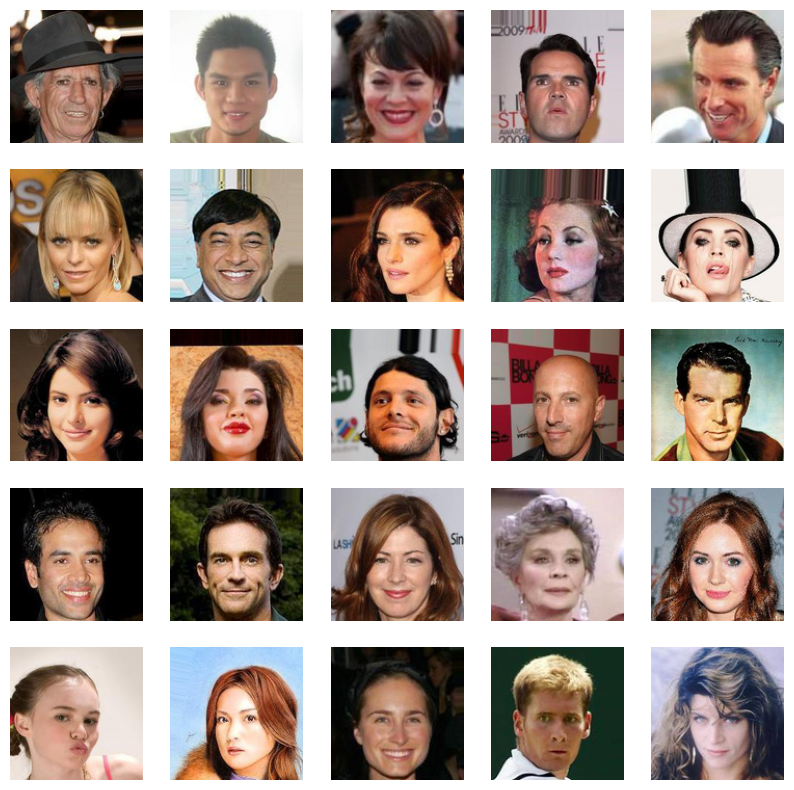

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import zipfile

# Especifique o caminho para o arquivo ZIP carregado (por exemplo, "/content/arquivo.zip")
caminho_arquivo_zip = "/content/drive/MyDrive/val/img_align_celeba.zip"

# Diretório para extrair o conteúdo do arquivo ZIP
pasta_destino = "/content/drive/MyDrive/val"

# Descompactar o arquivo ZIP
with zipfile.ZipFile(caminho_arquivo_zip, 'r') as zip_ref:
    zip_ref.extractall(pasta_destino)

PIC_DIR = '/content/drive/MyDrive/val/img_align_celeba/'
IMAGES_COUNT = 10000
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic)) #Normalize the images
images = np.array(images) / 255
images.shape #print first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

### Define e retorna um modelo de gerador usando a arquitetura de rede neural convolucional. O gerador é responsável por criar novas imagens a partir de um vetor de entrada. O modelo possui camadas densas, camadas convolucionais transpostas e camadas convolucionais para construir as imagens desejadas. A ativação final da camada de saída é uma tangente hiperbólica para normalizar os valores dos pixels da imagem gerada.

In [ ]:
LATENT_DIM = 32
CHANNELS = 3
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

### Define e retorna um modelo de discriminador usando a arquitetura de rede neural convolucional. O discriminador é responsável por classificar se uma imagem é real ou falsa (gerada pelo gerador). O modelo possui camadas convolucionais para extrair características da imagem de entrada e utiliza a função de ativação LeakyReLU para introduzir não-linearidades. No final, o modelo faz a classificação binária através de uma camada densa com ativação sigmoide. O modelo é compilado com um otimizador RMSprop e a perda é definida como a entropia cruzada binária.

In [ ]:

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [ ]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import RMSprop




### Cria um modelo adversarial chamado GAN (Generative Adversarial Network). O GAN consiste em um gerador e um discriminador. O gerador é responsável por criar novas imagens a partir de um vetor de entrada, enquanto o discriminador é responsável por classificar se uma imagem é real ou falsa. O discriminador é treinado separadamente e seu treinamento é desativado durante o treinamento do GAN. O GAN é compilado com um otimizador RMSprop e a perda é definida como a entropia cruzada binária.

In [ ]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)#Adversarial Model
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
import time


### Realiza o treinamento de uma rede generativa adversarial (GAN) para gerar imagens falsas semelhantes a um conjunto de imagens reais. A GAN é treinada em um loop iterativo. A cada iteração, o gerador cria um conjunto de imagens falsas a partir de vetores de entrada aleatórios. Essas imagens falsas são combinadas com um conjunto correspondente de imagens reais. O discriminador é treinado para classificar corretamente as imagens como reais ou falsas. Em seguida, o gerador é treinado para enganar o discriminador, tentando gerar imagens que sejam classificadas como reais. Os erros de treinamento do discriminador e do gerador são registrados. Além disso, em determinados intervalos de iterações, algumas imagens geradas são salvas e o progresso do treinamento é exibido.

In [ ]:

iters = 5000
batch_size = 16
RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0
i = 0
for step in range(iters):
    i = i+1
    print(i)
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 31ms/step
57
1/1 [==============================] - 0s 17ms/step
58
1/1 [==============================] - 0s 18ms/step
59
1/1 [==============================] - 0s 18ms/step
60
1/1 [==============================] - 0s 19ms/step
61
1/1 [==============================] - 0s 18ms/step
62
1/1 [==============================] - 0s 29ms/step
63
1/1 [==============================] - 0s 18ms/step
64
1/1 [==============================] - 0s 18ms/step
65
1/1 [==============================] - 0s 17ms/step
66
1/1 [==============================] - 0s 18ms/step
67
1/1 [==============================] - 0s 19ms/step
68
1/1 [==============================] - 0s 26ms/step
69
1/1 [==============================] - 0s 18ms/step
70
1/1 [==============================] - 0s 18ms/step
71
1/1 [==============================] - 0s 18ms/step
72
1/1 [==============================] - 0s 17ms/step
73
1/1 [=